<a href="https://colab.research.google.com/github/MrckHckr/artemis2-go-tests/blob/main/notebooks/04_avionics_gnc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avionics & GNC
# Obiettivo
Verificare che Orion mantenga assetto stabile, abbia errore di navigazione sotto soglia, non mostri anomalie avioniche, dia GO / NO-GO

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

np.random.seed(42)


In [2]:
# Simulazione assetto (roll, pitch, yaw)
# Tempo simulato (secondi)
time = np.arange(0, 600)

# Assetto nominale (gradi)
roll = np.random.normal(0, 0.15, len(time))
pitch = np.random.normal(0, 0.2, len(time))
yaw = np.random.normal(0, 0.15, len(time))

# Inseriamo disturbi simulati
roll[250] += 2.5
pitch[400] -= 3.0

df_attitude = pd.DataFrame({
    "time_s": time,
    "roll_deg": roll,
    "pitch_deg": pitch,
    "yaw_deg": yaw
})

df_attitude.head()


,time_s,roll_deg,pitch_deg,yaw_deg
0,0,0.074507,0.151398,0.018784
1,1,-0.020740,-0.184433,-0.064411
2,2,0.097153,0.173921,0.018345
3,3,0.228454,0.271128,0.081495
4,4,-0.035123,0.082687,0.007329


In [3]:
# Errore di navigazione
# Errore di posizione (metri)
position_error = np.abs(np.random.normal(2, 0.8, len(time)))

# Introduciamo errore critico
position_error[380] += 15

df_nav = pd.DataFrame({
    "time_s": time,
    "position_error_m": position_error
})

df_nav.head()


,time_s,position_error_m
0,0,3.520953
1,1,1.951471
2,2,1.433275
3,3,0.789028
4,4,0.557488


In [4]:
# Anomaly Detection GNC
# Uniamo assetto + navigazione
df_gnc = pd.concat([df_attitude.drop(columns="time_s"),
                     df_nav["position_error_m"]], axis=1)

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_gnc)

# Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df_gnc["anomaly"] = model.fit_predict(X_scaled)

df_gnc.head()


,roll_deg,pitch_deg,yaw_deg,position_error_m,anomaly
0,0.074507,0.151398,0.018784,3.520953,1
1,-0.020740,-0.184433,-0.064411,1.951471,1
2,0.097153,0.173921,0.018345,1.433275,1
3,0.228454,0.271128,0.081495,0.789028,1
4,-0.035123,0.082687,0.007329,0.557488,1


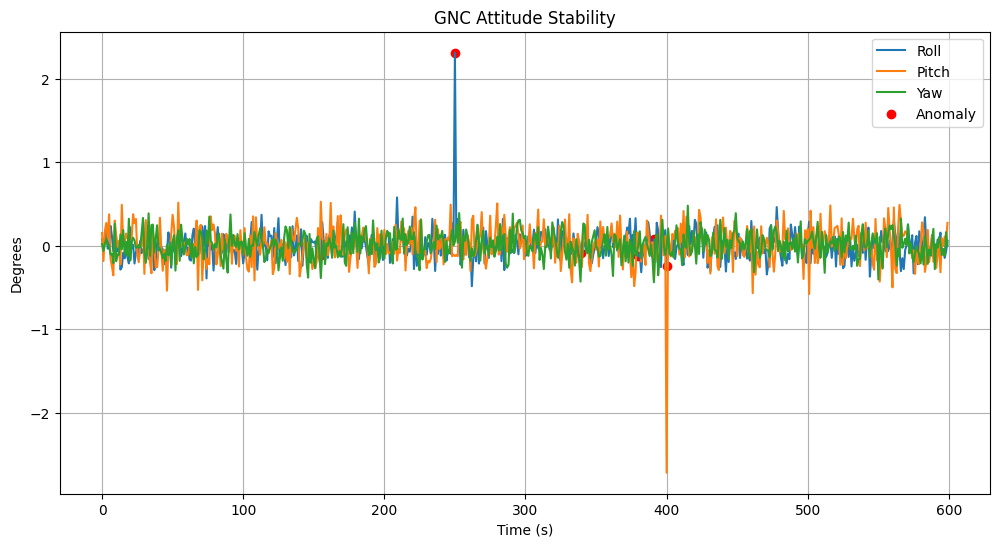

In [5]:
# Visualizzazione
plt.figure(figsize=(12,6))

plt.plot(time, roll, label="Roll")
plt.plot(time, pitch, label="Pitch")
plt.plot(time, yaw, label="Yaw")
plt.scatter(time[df_gnc["anomaly"] == -1],
            roll[df_gnc["anomaly"] == -1],
            color="red", label="Anomaly")

plt.xlabel("Time (s)")
plt.ylabel("Degrees")
plt.title("GNC Attitude Stability")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Verifica requisiti di controllo
# Limiti missione
MAX_ATTITUDE_ERROR = 5      # gradi
MAX_POSITION_ERROR = 10     # metri

attitude_violation = (
    (np.abs(roll) > MAX_ATTITUDE_ERROR) |
    (np.abs(pitch) > MAX_ATTITUDE_ERROR) |
    (np.abs(yaw) > MAX_ATTITUDE_ERROR)
).sum()

position_violation = (position_error > MAX_POSITION_ERROR).sum()

print("Violazioni assetto:", attitude_violation)
print("Violazioni posizione:", position_violation)


Violazioni assetto: 0
Violazioni posizione: 1


In [7]:
# Decisione GO / NO-GO Avionics & GNC
max_anomalies = 3
anomalies_detected = (df_gnc["anomaly"] == -1).sum()

if attitude_violation > 0:
    decision = "❌ NO-GO — instabilità assetto"
elif position_violation > 0:
    decision = "❌ NO-GO — errore navigazione eccessivo"
elif anomalies_detected > max_anomalies:
    decision = "❌ NO-GO — anomalie avioniche"
else:
    decision = "✅ GO — GNC stabile e conforme"

print(decision)
print(f"Anomalie rilevate: {anomalies_detected}")
print(f"Violazioni assetto: {attitude_violation}")
print(f"Violazioni navigazione: {position_violation}")


❌ NO-GO — errore navigazione eccessivo
Anomalie rilevate: 6
Violazioni assetto: 0
Violazioni navigazione: 1
